# AMR RISK CLASSIFICATION IN LIVE-STOCKS

### DATA PRE-PROCESSESING

In this first part of the notebook, the needed pre-processing has been performed in order prepare the data for the analysis.

In [1]:
# LIBRARIES

# Basics
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import math
import pylab as pl


# Scikit learn - models
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression # used for RFE
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.calibration import calibration_curve


# Scikit learn - feature engineering 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier

/Users/aydanselek/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/Users/aydanselek/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


##### READ THE DATA

There are 5 different datasets: 3 of them are for the AMR test results and 2 of them are for the antibitic consumption. They are collected / extracted from database in various formats and years.

In [2]:
# read all test data I have
amr_data1 = pd.read_csv("New_test_data.txt", sep="\t", header=None) #2002-2015
amr_data2 = pd.read_excel("AMR data.xlsx") #2018
amr_data3 = pd.read_excel("AMR data 2017.xlsx") #2017

In [3]:
# read all consumption data I have
consumption_data1 = pd.read_excel('consumption_2013.xlsx') #2013
consumption_data2 = pd.read_csv('Drug Consumption data.csv') #2014-2017

##### RENAMING THE COLUMNS AND DIMENTION REDUCTION

It is needed to fix the same names across different datasets. This chunk of the code serves also for keeping the needed columns v.v. droping the unnecessary columns.

In [4]:
# amr_data1
amr_data1 = amr_data1.rename(index=str, columns={0: "Year", 6:"Active_principle", 7:"Farm_ID", 9:"Result", 10:"Bacteria", 12:"Kind"}) # this data was without header, renaming of columns 
amr_data1 = amr_data1[['Year', 'Active_principle', 'Farm_ID', 'Result', 'Bacteria', 'Kind']] # the columns I need
amr_data1 = amr_data1.loc[amr_data1['Kind'].isin(['SUINO', 'SUINO - SVEZZAMENTO', 'SUINO - SOTTOSCROFA', 'SUINO - MAGRONE', 'SUINO - SCROFETTA', 'SUINO - INGRASSO', 'SUINO - SCROFA', 'SUINO - VERRO', 'SUINO DI RAZZA MORA', 'SUINO DI RAZZA CINTA SENESE'])] # Only Suino

In [5]:
# amr_data2
amr_data2 = amr_data2.rename(index=str, columns={'AnnoConferimento': "Year", 'Antibiotico':"Active_principle", 'Codice_Allevix':"Farm_ID", 'Risultato':"Result", 'AgenteEziologico':"Bacteria", 'Specie':"Kind"}) # this data was with italian header, renaming of columns 
amr_data2 = amr_data2[['Year', 'Active_principle', 'Farm_ID', 'Result', 'Bacteria', 'Kind']] # the columns I need
amr_data2 = amr_data2.loc[amr_data2['Kind'].isin(['SUINO', 'SUINO - SVEZZAMENTO', 'SUINO - SOTTOSCROFA', 'SUINO - MAGRONE', 'SUINO - SCROFETTA', 'SUINO - INGRASSO', 'SUINO - SCROFA'])] # Only Suino

In [6]:
# amr_data3
amr_data3 = amr_data3.rename(index=str, columns={'AnnoConferimento': "Year", 'Antibiotico':"Active_principle", 'Codice_Allevix':"Farm_ID", 'Risultato':"Result", 'AgenteEziologico':"Bacteria", 'Specie':"Kind"}) # this data was with italian header, renaming of columns 
amr_data3 = amr_data3[['Year', 'Active_principle', 'Farm_ID', 'Result', 'Bacteria', 'Kind']] # the columns I need
amr_data3 = amr_data3.loc[amr_data3['Kind'].isin(['SUINO', 'SUINO - SVEZZAMENTO', 'SUINO - SOTTOSCROFA', 'SUINO - MAGRONE', 'SUINO - SCROFETTA', 'SUINO - INGRASSO', 'SUINO - SCROFA', 'SUINO - VERRO'])] # Only Suino

In [7]:
# consumption_data1
consumption_data1 = consumption_data1[['PK_Somministrazione', 'IdAllevamento', 'Year', 'CicloAperto', 'CicloChiuso', 
                     'Sito1', 'Sito3', 'TipoFarmaco', 'Target', 'PrincipioAttivo', 'PrincipioSomministratoMg',
                     'DDDA_Mille','DCDA_Mille']] # the columns I need

consumption_data1 = consumption_data1.rename(index=str, columns={'Year': "Year", 'PK_Somministrazione':"PK_Somministrazione", 'IdAllevamento':"Farm_ID", 'PrincipioAttivo':"Active_principle", 'CicloAperto': 'Open_cycle', 'CicloChiuso': 'Close_cycle', 
                     'Sito1': 'Site1', 'Sito3': 'Site3', 'TipoFarmaco': 'Type_of_medication', 'Target': 'Target', 'PrincipioSomministratoMg': 'Active_principle_mg',
                     'DDDA_Mille': 'DDDA','DCDA_Mille': 'DCDA'}) # rename in English

In [8]:
# consumption_data2
consumption_data2 = consumption_data2[['PK_Somministrazione', 'IdAllevamento', 'n_AnnoSomm', 'CicloAperto', 'CicloChiuso', 
                     'Sito1', 'Sito3', 'TipoFarmaco', 'Target', 'PrincipioAttivo', 'PrincipioSomministratoMg',
                     'DDDA_Mille','DCDA_Mille']] # the columns I need

consumption_data2 = consumption_data2.rename(index=str, columns={'n_AnnoSomm': "Year", 'PK_Somministrazione':"PK_Somministrazione", 'IdAllevamento':"Farm_ID", 'PrincipioAttivo':"Active_principle", 'CicloAperto': 'Open_cycle', 'CicloChiuso': 'Close_cycle', 
                     'Sito1': 'Site1', 'Sito3': 'Site3', 'TipoFarmaco': 'Type_of_medication', 'Target': 'Target', 'PrincipioSomministratoMg': 'Active_principle_mg',
                     'DDDA_Mille': 'DDDA','DCDA_Mille': 'DCDA'}) # rename in English

##### UPPERCASE

All the values in string need to turn in uppercase to unify the format.

In [9]:
amr_data1 = amr_data1.applymap(lambda s:s.upper() if type(s) == str else s)
amr_data2 = amr_data2.applymap(lambda s:s.upper() if type(s) == str else s)
amr_data3 = amr_data3.applymap(lambda s:s.upper() if type(s) == str else s)

In [10]:
consumption_data1 = consumption_data1.applymap(lambda s:s.upper() if type(s) == str else s)
consumption_data2 = consumption_data2.applymap(lambda s:s.upper() if type(s) == str else s)

##### MERGING ALL THE AMR TEST DATA AND THE CONSUMPTION DATA

The AMR test results data and the antibiotic consumption data can be merged in two datesets.

In [11]:
frames = [amr_data1, amr_data2, amr_data3]
amr_data = pd.concat(frames, ignore_index=True)

In [12]:
amr_data.head()

,Year,Active_principle,Farm_ID,Result,Bacteria,Kind
0,2013,AMINOSIDINA,000EX000,RESISTENTE,ESCHERICHIA COLI EMOLITICO,SUINO
1,2013,APRAMICINA,000EX000,RESISTENTE,ESCHERICHIA COLI EMOLITICO,SUINO
2,2013,CEFQUINOME,000EX000,SENSIBILE,ESCHERICHIA COLI EMOLITICO,SUINO
3,2013,CEFTIOFUR,000EX000,SENSIBILE,ESCHERICHIA COLI EMOLITICO,SUINO
4,2013,COLISTINA,000EX000,SENSIBILE,ESCHERICHIA COLI EMOLITICO,SUINO


In [13]:
frames2 = [consumption_data1, consumption_data2]
consumption_data = pd.concat(frames2, ignore_index=True)

In [14]:
consumption_data.head()

,PK_Somministrazione,Farm_ID,Year,Open_cycle,Close_cycle,Site1,Site3,Type_of_medication,Target,Active_principle,Active_principle_mg,DDDA,DCDA
0,327,001MN006,2013,0,0,0,0,INJ,---,AMPICILLIN,23825.0,2500.00,1250.00
1,327,001MN006,2013,0,0,0,0,INJ,---,DICLOXACILLIN,11950.0,2500.00,1250.00
2,328,001MN006,2013,0,0,0,0,ORAL POWD,---,DOXYCYCLINE,1000000.0,100000.00,20000.00
3,329,001MN006,2013,0,0,0,0,INJ,---,FLORFENICOL,75000.0,10000.00,2500.00
4,330,001MN006,2013,0,0,0,0,PREMIX,---,COLISTIN,1440000.0,261818.18,29090.91


##### ACTIVE PRINCIPLE CELANING AND THE IMPORTANCE OF THE ANTIBIOTICS 

The amr_data has some problems for the active principle which cannot be solvable in an automated manner. Some of the active principle are in Italian language, some of them are in English language. There are typos which is not easy to understand typo of which language. More over there are some active principle which are translated not in a proper way. 
Because of these problems I collected all unique values of "Active Principle" to create a mapping excel with right names. This will let me compare the active principle across the datasets.
More over, I added to this excel another column where I classified the importance of the active priciples, such as;
1 - VCIA: Veterinary Critically Important Antimicrobials 
2 - VHIA: Veterinary Highly Important Antimicrobials 
3 - VIA: Veterinary Important Antimicrobials

In [15]:
active_principle_info = pd.read_excel("Active_principle_map.xlsx")

In [16]:
active_principle_info.head()

,Active_principle,English_name,Value
0,ACIDO FUSIDICO,FUSIDIC ACID,3.0
1,ACIDO NALIDIXICO,NALIDIXIC ACID,2.0
2,ACIDO OXOLINICO,OXOLINIC ACID,2.0
3,AMIKACINA,AMIKACIN,1.0
4,AMINOSIDINA,PAROMOMYCIN,1.0


In [17]:
amr_data_ap = pd.merge(amr_data, active_principle_info, on='Active_principle', how='inner')

In [18]:
amr_data_ap = amr_data_ap.drop(['Active_principle'], axis=1)

In [19]:
amr_data_ap = amr_data_ap.rename(index=str, columns={'English_name': "Active_principle"})

##### TRANSLATE THE VALUES IN ENGLISH AND CHANGING THE NUMBER OF RESULT FROM 3 TO 2

It is nice to work always in same language. Here the 'Result' column values translated in English.

On the other hand, using Intermediate result won't give so much. For this reason, I decrease number of class from  3 to 2.

In [20]:
amr_data_ap.Result.replace(['RESISTENTE', 'SENSIBILE', 'INTERMEDIO'], ['RESISTANT', 'SENSITIVE', 'RESISTANT'], inplace=True)

##### DATA TRANSFORMATION - AGGREGATE THE RELATED CONSUMPTIONS

Because of the unautomated data collection and the nature of the drug consumption, there are multiple lines for each antibiotic consumption. For the health of the analysis, it is needed to sum same antibiotic comsumption which are belong to same farm, same year, same methodology and same type of medication.

In [21]:
# Drop more column 
consumption_data = consumption_data.drop(['PK_Somministrazione', 'Site1', 'Site3', 'Target'], axis=1)
amr_data_ap = amr_data_ap.drop(['Kind'], axis=1)

In [22]:
# New dataframe with grouped features
consumption_data_grouped = consumption_data.groupby(['Farm_ID', 'Year', 'Open_cycle', 'Close_cycle', 'Type_of_medication', 'Active_principle'], as_index= False).sum()

In [23]:
len(consumption_data_grouped) # 8421 records less!!

10431

##### CREATE THE GIANT DATASET

In [77]:
all_data = pd.merge(amr_data_ap, consumption_data_grouped, on=['Year', 'Farm_ID', 'Active_principle'], how='inner')

In [78]:
all_data = all_data[['Year', 'Farm_ID', 'Bacteria', 'Active_principle', 'Value', 'Open_cycle', 'Close_cycle', 'Type_of_medication', 'Active_principle_mg', 'DDDA', 'DCDA', 'Result']]

In [79]:
all_data2 = all_data.groupby(['Year', 'Farm_ID', 'Bacteria', 'Active_principle', 
                              'Value', 'Open_cycle', 'Close_cycle', 'Type_of_medication', 
                              'Result'], as_index= False).sum()

In [80]:
len(all_data2)

3836

##### DATA PREPARATION FOR THE ANAYSIS

In [81]:
# Drop the identify columns
dataset = all_data2

In [82]:
# Drop nan values
dataset.dropna(inplace=True)

### EDA

In [83]:
dataset.head()

,Year,Farm_ID,Bacteria,Active_principle,Value,Open_cycle,Close_cycle,Type_of_medication,Result,Active_principle_mg,DDDA,DCDA
0,2013,001MN006,ESCHERICHIA COLI EMOLITICO,COLISTIN,2.0,0,0,PREMIX,SENSITIVE,1440000.0,261818.18,29090.91
13,2013,002MN141,BRACHYSPIRA HYODYSENTERIAE,LINCOMYCIN,2.0,0,0,ORAL POWD,RESISTANT,1665000.0,500000.00,71428.57
14,2013,002MN141,BRACHYSPIRA HYODYSENTERIAE,TIAMULIN,2.0,0,0,ORAL POWD,SENSITIVE,11008800.0,925109.24,231277.31
15,2013,002MN141,BRACHYSPIRA HYODYSENTERIAE,TIAMULIN,2.0,0,0,PREMIX,SENSITIVE,8624000.0,1724800.00,344960.00
16,2013,002MN141,ESCHERICHIA COLI,AMOXICILLIN,1.0,0,0,INJ,RESISTANT,262500.0,35000.00,11666.67


In [84]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3408 entries, 0 to 3835
Data columns (total 12 columns):
Year                   3408 non-null int64
Farm_ID                3408 non-null object
Bacteria               3408 non-null object
Active_principle       3408 non-null object
Value                  3408 non-null float64
Open_cycle             3408 non-null int64
Close_cycle            3408 non-null int64
Type_of_medication     3408 non-null object
Result                 3408 non-null object
Active_principle_mg    3408 non-null float64
DDDA                   3408 non-null float64
DCDA                   3408 non-null float64
dtypes: float64(4), int64(3), object(5)
memory usage: 346.1+ KB


In [85]:
dataset.shape #Dataset comprises of 3408 observations and 12 characteristics. 
#Out of which one is dependent variable and rest 11 are independent variables.

(3408, 12)

In [86]:
dataset.describe()

,Year,Value,Open_cycle,Close_cycle,Active_principle_mg,DDDA,DCDA
count,3408.000000,3408.00000,3408.000000,3408.000000,3.408000e+03,3.408000e+03,3.408000e+03
mean,2014.328932,1.22858,0.646714,0.032570,3.213229e+07,3.234857e+06,6.457179e+05
std,0.908213,0.41998,0.478061,0.177535,1.323351e+08,1.199938e+07,2.337997e+06
min,2013.000000,1.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,2014.000000,1.00000,0.000000,0.000000,2.500000e+05,7.062500e+04,1.676364e+04
50%,2014.000000,1.00000,1.000000,0.000000,2.179500e+06,4.000000e+05,8.402976e+04
75%,2015.000000,1.00000,1.000000,0.000000,1.800000e+07,1.814182e+06,3.871875e+05
max,2017.000000,2.00000,1.000000,1.000000,3.420000e+09,3.040000e+08,3.817500e+07


Depending on these various summary statistics, it is possible to say there are some outliers (extreme values) for farms, bacteria and active principle. It is possible have this information if the mean value is less than median value and if there is large difference between 75th quantile and maximum values of predictors.

In [113]:
forboxplot = dataset[['Bacteria','Farm_ID','Active_principle','Active_principle_mg','DDDA','DCDA']]

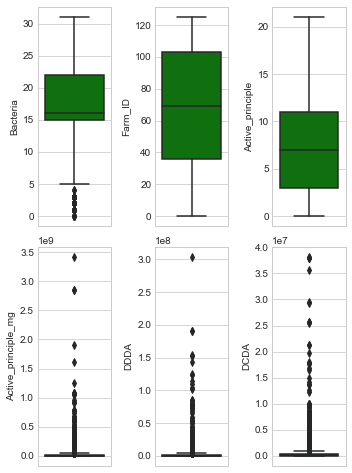

In [114]:
l = forboxplot.columns.values
number_of_columns=3
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(5,10))
for i in range(0,len(l)):
    plt.subplot(3,3,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(forboxplot[l[i]],color='green',orient='v')
    plt.tight_layout()

/Users/aydanselek/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


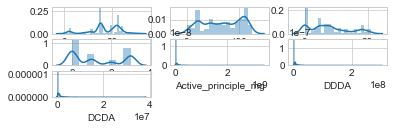

In [98]:
# plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(dataset[l[i]],kde=True) 

In [34]:
dataset.corr()

,Year,Value,Open_cycle,Close_cycle,Active_principle_mg,DDDA,DCDA
Year,1.000000,-0.013265,0.110890,0.020913,-0.038745,-0.035386,-0.031731
Value,-0.013265,1.000000,-0.075711,-0.009339,-0.023319,0.045962,0.032085
Open_cycle,0.110890,-0.075711,1.000000,-0.248253,0.007388,0.014952,0.018291
Close_cycle,0.020913,-0.009339,-0.248253,1.000000,-0.027277,-0.028311,-0.027555
Active_principle_mg,-0.038745,-0.023319,0.007388,-0.027277,1.000000,0.922654,0.875888
DDDA,-0.035386,0.045962,0.014952,-0.028311,0.922654,1.000000,0.958631
DCDA,-0.031731,0.032085,0.018291,-0.027555,0.875888,0.958631,1.000000


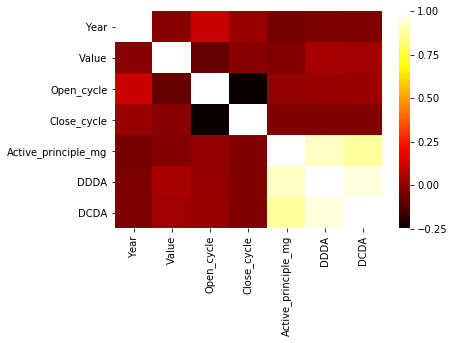

In [35]:
import seaborn as sns
corr = dataset.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='hot')

### FEATURE ANAYLSIS

In [140]:
dataset_R = dataset[dataset.Result == 'RESISTANT']
dataset_S = dataset[dataset.Result == 'SENSITIVE']

##### LIVING CONDITIONS

##### TYPE OF MEDICATION

In [103]:
data_R_tom = dataset_R.groupby(['Type_of_medication'])['Result'].count()
data_S_tom = dataset_S.groupby(['Type_of_medication'])['Result'].count()

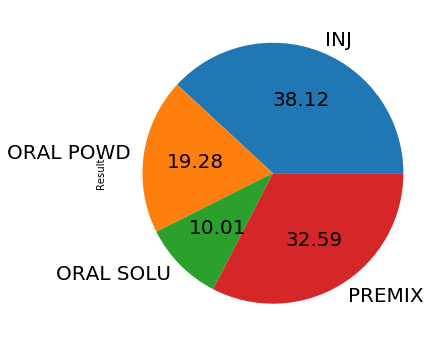

In [104]:
data_R_tom.plot.pie(autopct='%.2f', fontsize=20, figsize=(6, 6))

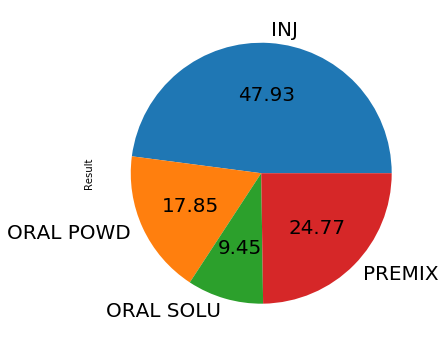

In [105]:
data_S_tom.plot.pie(autopct='%.2f', fontsize=20, figsize=(6, 6))

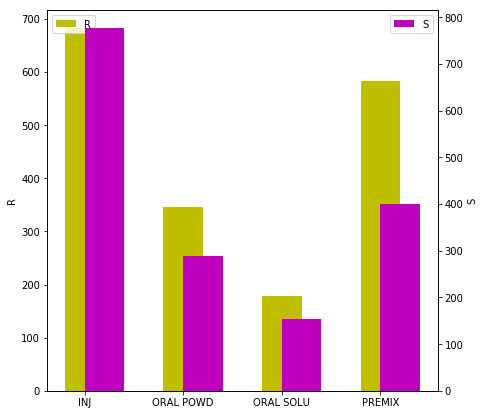

In [106]:
fig = pl.figure(figsize=(7,7))
ax1 = pl.subplot(111,ylabel='R')
ax2 =ax1.twinx()
ax2.set_ylabel('S')
ax1.bar(data_R_tom.index, data_R_tom.values, width =0.4, color ='y', align = 'center')
ax2.bar(data_S_tom.index, data_S_tom.values, width = 0.4, color='m', align = 'edge')
ax1.legend(['R'], loc = 'upper left')
ax2.legend(['S'], loc = 'upper right')

##### ACTIVE PRINCIPLE

In [107]:
data_R_ap = dataset_R.groupby(['Active_principle'])['Result'].count()
data_S_ap = dataset_S.groupby(['Active_principle'])['Result'].count()

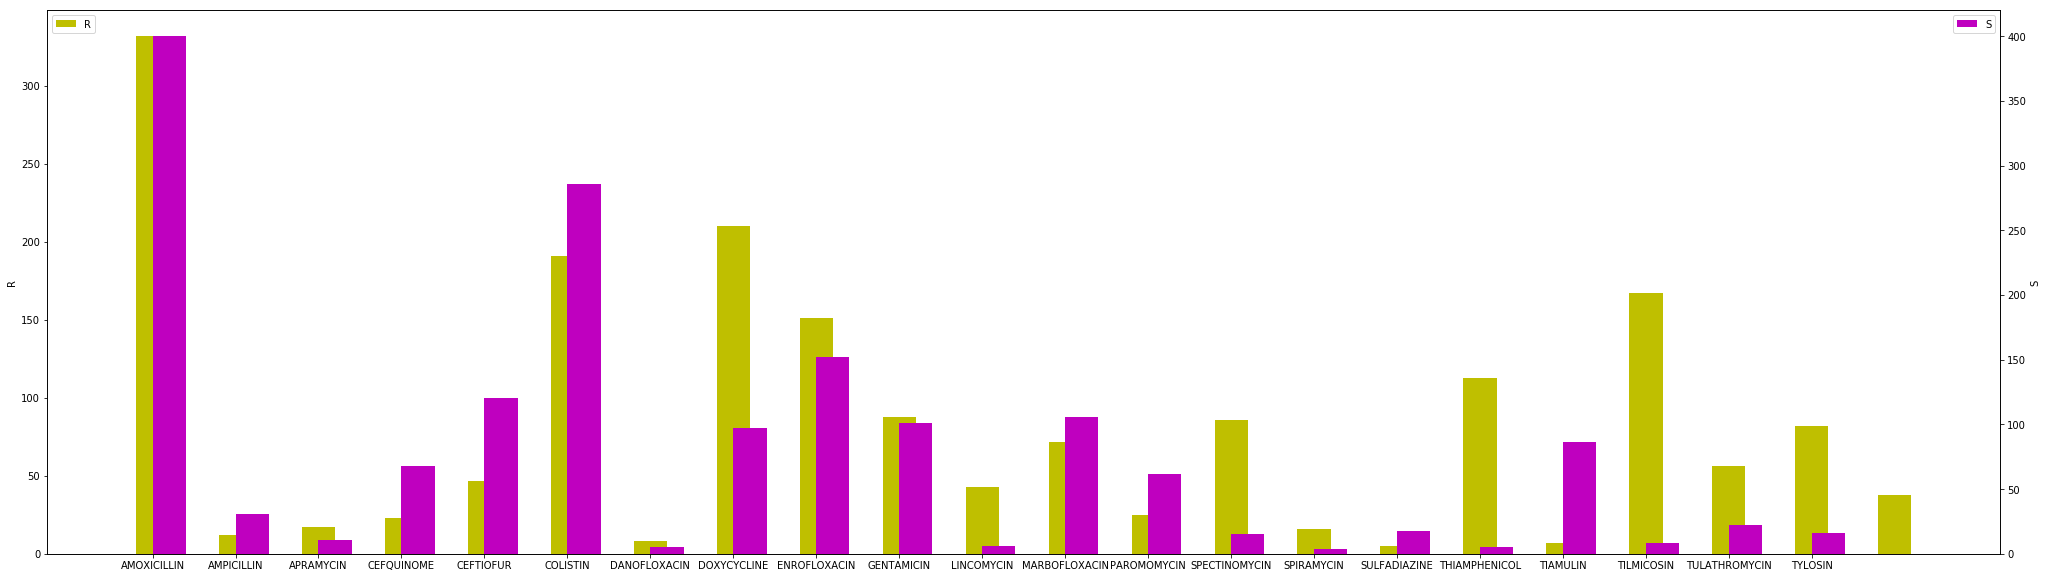

In [108]:
fig = pl.figure(figsize=(35,10))
ax1 = pl.subplot(111,ylabel='R')
ax2 =ax1.twinx()
ax2.set_ylabel('S')
ax1.bar(data_R_ap.index,data_R_ap.values, width =0.4, color ='y', align = 'center')
ax2.bar(data_S_ap.index,data_S_ap.values, width = 0.4, color='m', align = 'edge')
ax1.legend(['R'], loc = 'upper left')
ax2.legend(['S'], loc = 'upper right')

##### BACTERIA

In [109]:
data_R_b = dataset_R.groupby(['Bacteria'])['Result'].count()
data_S_b = dataset_S.groupby(['Bacteria'])['Result'].count()

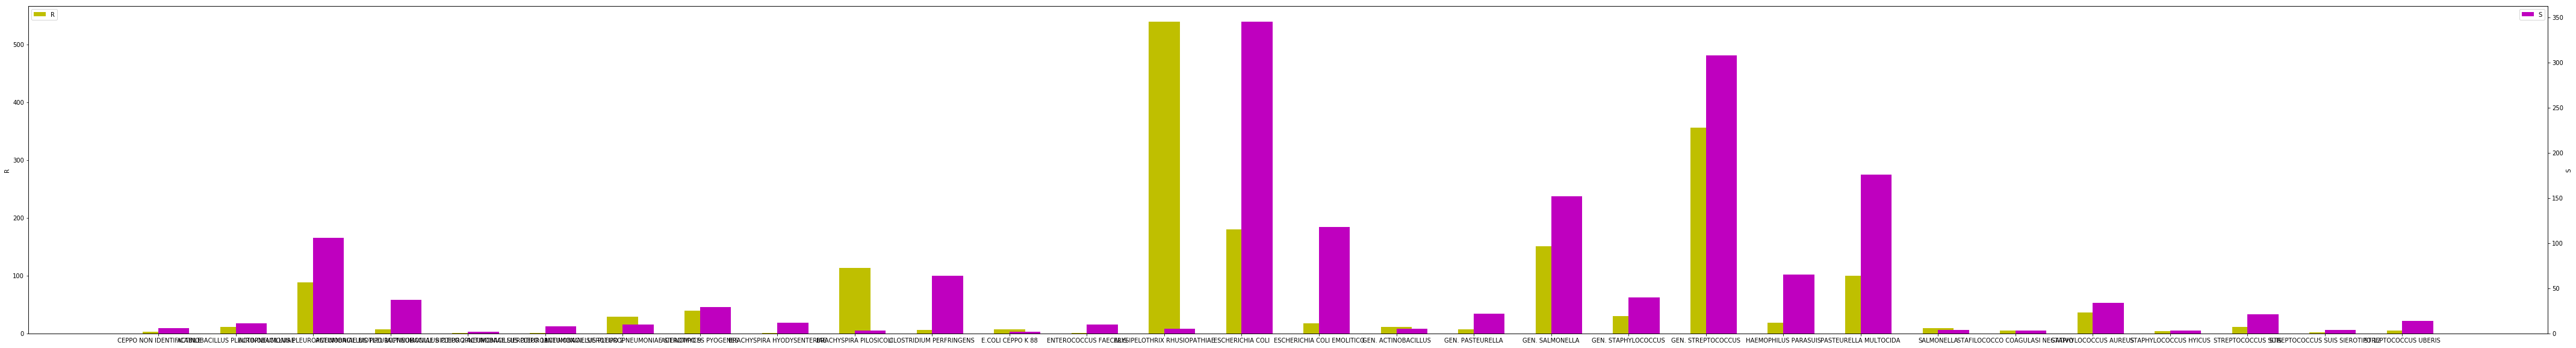

In [110]:
fig = pl.figure(figsize=(75,10))
ax1 = pl.subplot(111,ylabel='R')
ax2 =ax1.twinx()
ax2.set_ylabel('S')
ax1.bar(data_R_b.index,data_R_b.values, width =0.4, color ='y', align = 'center')
ax2.bar(data_S_b.index,data_S_b.values, width = 0.4, color='m', align = 'edge')
ax1.legend(['R'], loc = 'upper left')
ax2.legend(['S'], loc = 'upper right')

##### PREPARING THE DATA FOR MODELLING

##### MEAN REMOVAL (STANDARDIZATION)

In [43]:
scaler = preprocessing.MinMaxScaler()
dataset[['Active_principle_mg', 'DDDA', 'DCDA']] = scaler.fit_transform(dataset[['Active_principle_mg', 'DDDA', 'DCDA']])
print('Mean after=', dataset.mean(axis=0))
print('Standard Deviation after=', dataset.std(axis=0))

Mean after= Year                    1.276995
Farm_ID                67.442488
Bacteria               17.051937
Active_principle        7.717723
Value                   1.228580
Open_cycle              0.646714
Close_cycle             0.032570
Type_of_medication      1.247066
Result                  0.475059
Active_principle_mg     0.009395
DDDA                    0.010641
DCDA                    0.016915
dtype: float64
Standard Deviation after= Year                    0.772380
Farm_ID                36.641228
Bacteria                6.365213
Active_principle        6.258225
Value                   0.419980
Open_cycle              0.478061
Close_cycle             0.177535
Type_of_medication      1.272634
Result                  0.499451
Active_principle_mg     0.038694
DDDA                    0.039472
DCDA                    0.061244
dtype: float64


##### NORMALIZATION

In [205]:
dataset[['Active_principle_mg', 'DDDA', 'DCDA']] = preprocessing.normalize(dataset[['Active_principle_mg', 'DDDA', 'DCDA']], norm='l1')

##### DEALING WITH THE CATEGORICAL DATA / Label Encoder

In [91]:
pd.options.mode.chained_assignment = None

le_Bacteria = preprocessing.LabelEncoder()
le_Active_principle = preprocessing.LabelEncoder()
le_Type_of_medication = preprocessing.LabelEncoder()
le_Result = preprocessing.LabelEncoder()
le_Year = preprocessing.LabelEncoder()
le_Farm_ID = preprocessing.LabelEncoder()


dataset['Bacteria'] = le_Bacteria.fit_transform(dataset['Bacteria'])
dataset['Active_principle'] = le_Active_principle.fit_transform(dataset['Active_principle'])
dataset['Type_of_medication'] = le_Type_of_medication.fit_transform(dataset['Type_of_medication'])
dataset['Result'] = le_Result.fit_transform(dataset['Result'])
dataset['Farm_ID'] = le_Farm_ID.fit_transform(dataset['Farm_ID'])
dataset['Year'] = le_Year.fit_transform(dataset['Year'])

### FEATURE SELECTION

##### SPLITTING THE DATA FOR FEATURE SELECTION

In [207]:
X = dataset[['Year', 'Farm_ID', 'Bacteria', 'Active_principle', 'Value', 'Open_cycle', 'Close_cycle', 'Type_of_medication', 'Active_principle_mg','DDDA', 'DCDA']]
Y = dataset[['Result']]

In [208]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [209]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3067, 11)
(341, 11)
(3067, 1)
(341, 1)


Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

The chi squared statistical test for non-negative features to select 4 of the best features.

In [210]:
# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
unvariate = SelectKBest(score_func=chi2, k=4)
unvariate_fit = unvariate.fit(X, Y)
# summarize scores
np.set_printoptions(precision=3)
print(unvariate_fit.scores_)
features = unvariate_fit.transform(X)
 #VALUE, YEAR, DDDA, THE CLOSE CYCLE

[  5.245e-02   2.072e+02   1.076e+01   8.369e+02   6.022e-02   5.276e-01
   3.103e+00   4.608e+01   3.072e+00   9.943e-01   5.181e+00]


In [211]:
# Feature Extraction with RFE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

model = LogisticRegression(penalty='l1')
rfe = RFE(model, 4)
rfe_fit = rfe.fit(X, Y.values.ravel())
print(("Num Features: %d") % (rfe_fit.n_features_))
print(("Selected Features: %s") % rfe_fit.support_)
print(("Feature Ranking: %s") % rfe_fit.ranking_) #L1 ACTIVE PRINCIPLE, VALUE, CLOSE CYCLE, TYPE OF MEDICATION

Num Features: 4
Selected Features: [False False False False False  True  True False  True False  True]
Feature Ranking: [6 7 5 3 2 1 1 4 1 8 1]


In [212]:
model = LogisticRegression(penalty='l2')
rfe = RFE(model, 4)
rfe_fit = rfe.fit(X, Y.values.ravel())
print(("Num Features: %d") % (rfe_fit.n_features_))
print(("Selected Features: %s") % rfe_fit.support_)
print(("Feature Ranking: %s") % rfe_fit.ranking_) #L2 FARM ID, TOTAL MG OF ACTIVE PRINCIPLE, DDDA and DCDA

Num Features: 4
Selected Features: [False False False False False False  True False  True  True  True]
Feature Ranking: [7 8 6 4 3 2 1 5 1 1 1]


In [213]:
# Feature Extraction with PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalComponents2 = pca.fit(X)
# summarize components
#print(("Explained Variance: %s") % pca_fit.explained_variance_ratio_)
print(principalComponents2.components_)

[[  1.722e-03  -1.000e+00   5.124e-03   4.928e-03   1.586e-06  -7.964e-04
    1.285e-04  -1.238e-03  -2.750e-04   2.867e-05   1.805e-04]
 [  7.890e-03  -3.776e-03  -9.703e-01   2.415e-01   3.543e-03   4.782e-03
   -9.475e-04   3.043e-03  -1.129e-03   6.355e-04   3.438e-04]]


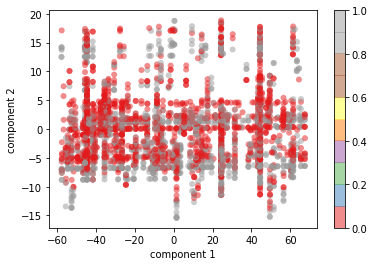

In [214]:
from matplotlib import cm
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],
            c=Y.values.ravel(), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Set1', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

In [215]:
# Feature Importance with Extra Trees Classifier
etc_model = ExtraTreesClassifier()
etc_model.fit(X, Y.values.ravel())
print(etc_model.feature_importances_) # BACTERIA, ACTIVE PRINCIPLE, DDDA, FARM ID

[ 0.064  0.157  0.415  0.105  0.015  0.025  0.007  0.021  0.067  0.058
  0.067]


### MODELS

For the advanced analytics, I selected 3 models to apply for. These are: K-Nearest Neighbor Classifier and Random Forest Classifier and Support Vector Machine.

In [248]:
X = dataset[['Bacteria', 'Active_principle', 'Value', 'Open_cycle', 'Close_cycle', 'Active_principle_mg']]
Y = dataset[['Result']]

In [249]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [250]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3067, 6)
(341, 6)
(3067, 1)
(341, 1)


In [251]:
# Preparing dictionaries to compare the classifiers
# K-Nearest Neighbor Classifier
KNN_dict = {"n_neighbors" : [2,3,5]}
# Random Forest Classifier
RFC_dict = {"n_estimators": [100,150,200], "max_depth": [3,50,100], "min_samples_split": [2,3,4]}
# Support Vector Machine Classifier
SVC_dict = { "C": [0.1, 0.5, 1, 5, 10, 50, 100] , "kernel": ['rbf'] }
cv = KFold(n_splits=10, random_state=42, shuffle=False)

In [252]:
matrix0 = np.zeros((len(KNN_dict["n_neighbors"])))
for i in range(len(KNN_dict["n_neighbors"])):
    n = KNN_dict["n_neighbors"][i]
    clf2 = KNeighborsClassifier(n_neighbors= n)
    scores2 = cross_val_score(clf2, X_train, Y_train.values.ravel(), cv=cv)
    matrix0[i] = sum(scores2)/len(scores2)
print(matrix0)
print("Max average score :", matrix0.max())
i = np.unravel_index(matrix0.argmax(), matrix0.shape)
print("Best n_neighbors value : ", KNN_dict["n_neighbors"][i[0]])

[ 0.636  0.67   0.694]
Max average score : 0.694454024824
Best n_neighbors value :  5


In [253]:
matrix1 = np.zeros((len(RFC_dict["n_estimators"]),len(RFC_dict["max_depth"]),len(RFC_dict["min_samples_split"])))
for i in range(len(RFC_dict["n_estimators"])):
    s = RFC_dict["n_estimators"][i]
    for j in range(len(RFC_dict["max_depth"])):
        m = RFC_dict["max_depth"][j]
        for z in range(len(RFC_dict["min_samples_split"])):
            mi = RFC_dict["min_samples_split"][z]
            clf3 = RandomForestClassifier(n_estimators= s, max_depth= m, min_samples_split = mi)
            scores3 = cross_val_score(clf3, X_train, Y_train.values.ravel(), cv=cv)
            matrix1[i][j][z] = sum(scores3)/len(scores3)
print(scores3)
print(matrix1)
print("Max average score :", matrix1.max())
i,j,z = np.unravel_index(matrix1.argmax(), matrix1.shape)
print("Best n_estimators value : ", RFC_dict["n_estimators"][i])
print("Best max_depth value : ", RFC_dict["max_depth"][j])
print("Best min_samples_split value : ", RFC_dict["min_samples_split"][z])

[ 0.73   0.681  0.704  0.671  0.642  0.668  0.691  0.601  0.66   0.657]
[[[ 0.644  0.646  0.645]
  [ 0.659  0.66   0.669]
  [ 0.658  0.655  0.671]]

 [[ 0.647  0.652  0.643]
  [ 0.655  0.662  0.668]
  [ 0.657  0.662  0.663]]

 [[ 0.642  0.64   0.645]
  [ 0.656  0.66   0.667]
  [ 0.65   0.658  0.67 ]]]
Max average score : 0.670661684869
Best n_estimators value :  100
Best max_depth value :  100
Best min_samples_split value :  4


In [254]:
matrix2 = np.zeros((len(SVC_dict["C"]),len(SVC_dict["kernel"])))
for i in range(len(SVC_dict["C"])):
    c = SVC_dict["C"][i]
    for j in range(len(SVC_dict["kernel"])):
        k = SVC_dict["kernel"][j]
        clf4 = SVC(kernel = k, C = c)
        scores4 = cross_val_score(clf4, X_train, Y_train.values.ravel(), cv=cv)
        matrix2[i][j] = sum(scores4)/len(scores4)
print(matrix2)
print("Max average score :", matrix2.max())
i,j = np.unravel_index(matrix2.argmax(), matrix2.shape)
print("Best C value : ", SVC_dict["C"][i])
print("Best kernel value : ", SVC_dict["kernel"][j])

[[ 0.699]
 [ 0.707]
 [ 0.719]
 [ 0.719]
 [ 0.714]
 [ 0.722]
 [ 0.723]]
Max average score : 0.722842817909
Best C value :  100
Best kernel value :  rbf


##### PREDICTION WITH THE BEST MODEL

In [255]:
# Which is the best combination for the prediction?
best_scores = np.array([matrix0.max(),matrix1.max(), matrix2.max()])
i = np.unravel_index(best_scores.argmax(), best_scores.shape)
best_scores
print("Best scores among the matrices:", best_scores[i], "of the matrix:", i)

Best scores among the matrices: 0.722842817909 of the matrix: (2,)


In [256]:
# Prediction with Cross Fold = 10 
cv = KFold(n_splits=10, random_state=42, shuffle=False)
best_classifier_forcv = SVC(kernel='rbf', C=50).fit(X_train, Y_train.values.ravel())
scores_cv = cross_val_score(best_classifier_forcv, X, Y.values.ravel(), cv=10)
print("The highest score with Cross Fold = 10:", scores_cv.max())

The highest score with Cross Fold = 10: 0.780058651026


In [257]:
# Prediction with simple splitting
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify = Y)
best_classifier_forsplit = SVC(kernel='rbf', C=50).fit(X_train, Y_train.values.ravel())
best_classifier_forsplit.fit(X_train, Y_train.values.ravel())
predicted_split = best_classifier_forsplit.predict(X_test)
print('Accuracy of Selected Classifier, on the training set:{:.3f}'.format(best_classifier_forsplit.score(X_train, Y_train.values.ravel())))
print('Accuracy of Selected Classifier, on the test set:{:.3f}'.format(best_classifier_forsplit.score(X_test, Y_test.values.ravel())))

Accuracy of Selected Classifier, on the training set:0.786
Accuracy of Selected Classifier, on the test set:0.736


[[137  42]
 [ 48 114]]


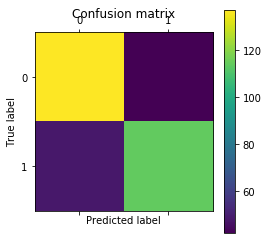

In [258]:
confusionmatrix = confusion_matrix(Y_test.values.ravel(), predicted_split)
print(confusionmatrix)
plt.matshow(confusionmatrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show() 

In [259]:
# Create classifiers
knn = KNeighborsClassifier(n_neighbors= 5)
rfc = RandomForestClassifier(n_estimators= 100, max_depth= 100, min_samples_split = 4)
svc = SVC(kernel = 'rbf', C = 50)

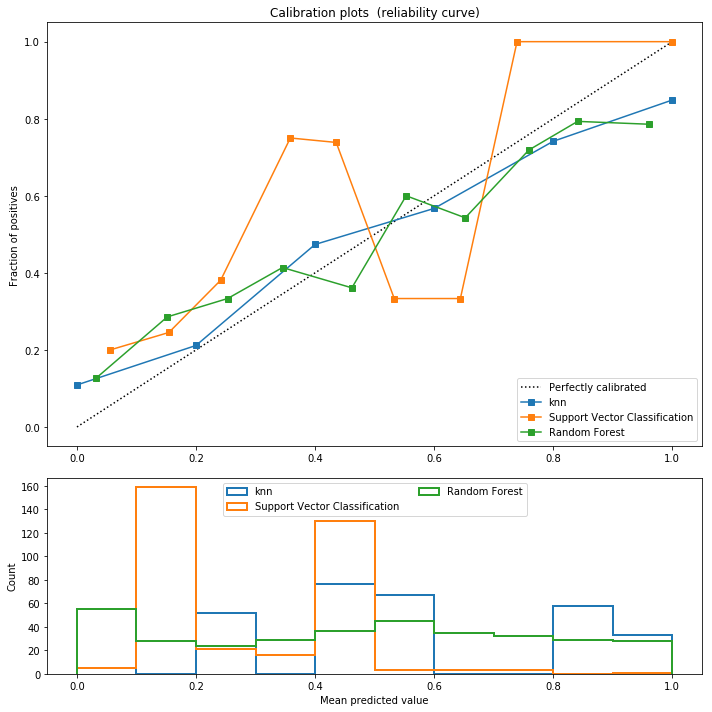

In [262]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for bok, name in [(knn, 'knn'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    bok.fit(X_train, Y_train.values.ravel())
    if hasattr(bok, "predict_proba"):
        prob_pos = bok.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = bok.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(Y_test.values.ravel(), prob_pos, n_bins=10, normalize=True)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()